In [ ]:
#Plan of action: Preform all the visualization from what I did in attempt 1; take that info and then ultimately reduce 
#the dimensions from the original review based on positive, negative and negation (not) words... Lemmatize that and 
#then run machine learning on that option... 

In [1]:
#Packages needed in this file: 
#To interact with the operating system 
import os 

# To create and manipulate dfs 
import pandas as pd 

#To create a wordcloud/graphs
import numpy as np 
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm 
from colorspacious import cspace_converter
import seaborn as sns
#Allows for randomization, you can set a seed to have reproducable results
import random

#from PIL import Image
from PIL import ImageFilter
import numpy as np
#Allows for several values for the same dictionary key 
import multidict

#To get a count of words (used in the term_frequency)
from collections import Counter 

#To process text using nltk (remove stopwords, lemmatize, tokenize...)
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
#Porter stemmer 
from nltk.stem.porter import PorterStemmer 
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#A new option to nltk: SPACY 
# import spacy 
# from spacy.lang.en import English

#To make the items you print look nicer and more readable 
#To make things look nicer when I print them 
from pprint import pprint 

#To perform machine learning in Naive Bayes I need to import the following packages 
from sklearn.model_selection import train_test_split 
# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB
# To calculate the accuracy score of the model
from sklearn.metrics import accuracy_score
#confusion matrix 
from sklearn.metrics import confusion_matrix, classification_report

In [96]:
#Functions that will be used in the file: 

#Function 1: 
    #What the function does: to be creating a list of reviews, then joining the reviews together to a string and 
                             #getting a count for each word in the string
    #Input: df and column 
    #Output: a dictionary with each word and the count of the word
def creating_freq_list_from_df_to_dict(df, column):
    reviews = df[column].tolist() 
    review_string = " ".join(reviews)
    review_string = review_string.split()
    review_dict = Counter(review_string)
    return review_dict

#Function 2: 
    #What the function does: creates a word cloud that is in the shape of the mask passed in
    #Input: the location where the mask image is saved, the frequency word dictionary, and the max # of words to include
            #and the title of the plot 
def create_word_cloud_with_mask(path_of_mask_image, dictionary, 
                                max_num_words, title):
        mask = np.array(Image.open(path_of_mask_image))
        #creating the word cloud 
        word_cloud = WordCloud(background_color = "white", 
                               max_words = max_num_words, 
                              mask = mask, max_font_size = 125, 
                              random_state = 1006)
        word_cloud.generate_from_frequencies(dictionary)
        #creating the coloring for the word cloud 
        image_colors = ImageColorGenerator(mask)
        plt.figure(figsize = [8,8])
        plt.imshow(word_cloud.recolor(color_func = image_colors), 
                  interpolation = "bilinear")
        plt.title(title)
        sns.set_context("poster")
        plt.axis("off")
        return plt
    
#Function 3: 
    #What the function does: creates a df with two columns: word and count of the top 12 words
    #Input: the word frequency dictionary 
    #Output: a df with the top 12 words 
def word_freq_dict_to_df_top_words(dictionary, number_of_words_wanted): 
    df = pd.DataFrame.from_dict(dictionary,orient='index')
    df.columns = ["count"]
    df["word"] = df.index
    df.reset_index(drop = True, inplace = True)
    df.sort_values(by=["count"], ascending = False, inplace = True)
    df = df[:number_of_words_wanted]
    return(df)

#Function 4: 
    #What the function does: creates a bar graph
    #Input: the df and title of the graph 
    #Output: the bar graph
def top_words_bar_plot(df, title): 
    graph = sns.barplot(y = "count", x = "word", data = df, 
                       palette = "GnBu_d")
    sns.set_context("talk")
    plt.title(title)
    plt.xlabel("Word")
    plt.ylabel("Count")
    sns.set_context("talk")
    plt.xticks(rotation = 90)
    return plt

#Function 5: 
    #What the function does: creates a df with two columns: word and count 
    #Input: the word frequency dictionary 
    #Output: a df
def word_freq_dict_to_df_all_words(dictionary): 
    df = pd.DataFrame.from_dict(dictionary,orient='index')
    df.columns = ["count"]
    df["word"] = df.index
    df.reset_index(drop = True, inplace = True)
    df.sort_values(by=["count"], ascending = False, inplace = True)
    return(df)

#Function 6: 
    #What the function does: Returns 2 statements: One with the total number of words and the other with the number 
                            #of unique words 
        #Input: the frequency count dictionary 
        #output: 2 statements 
def total_words_unique_words(dictionary): 
    eda_reviews_all_words = word_freq_dict_to_df_all_words(dictionary)
    print("The total number of words is", sum(eda_reviews_all_words["count"]))
    print("The total number of unique words is", len(dictionary)) 

#Function 7: removing stopwords
    #What the function does: Removes stopwords 
    #Input: the item that you want to remove stopwords in 
    #Output: the same item type back with the stopwords removed. 
def stop_word_removal(item_that_you_want_to_remove_stopwords_in): 
    removed_stopwords = [] 
    stop_words = stopwords.words("english")
    for word in item_that_you_want_to_remove_stopwords_in: 
        if word in stop_words: 
            continue
        if word not in stop_words: 
            removed_stopwords.append(word)
    return(removed_stopwords)

#Function 8: 
    #What the function does: It takes the tokens from the df and joins it into a string, then replaces the "," with a space
    #Input: the df and column to be changed 
    #Output: the data untokenized 
def getting_data_ready_for_freq(df, column): 
    df[column] = df[column].apply(",".join)
    df[column] = df[column].str.replace(",", " ")
    return(df[column])

#Function 9: 
    #What the function does: It uses the Porter stemmer to stem each word in the column 
    #Input: the item that you want to be stemmed 
    #Output: the same item type back with the words stemmed 
def stem_fun(item_that_you_want_to_be_stemmed):     
    stemmer = PorterStemmer() 
    stemmed = [stemmer.stem(token) for token in item_that_you_want_to_be_stemmed]
    return(stemmed)

#Function 10: 
    #What the function does: It lemmatizes the data without using pos, meaning that it will not be as efficient
    #Input: item to be lemmatized (the column)
    #Output: the column lemmatized 
def lemma_func(item_to_lemmatize):
    lemmatizer = WordNetLemmatizer()
    lemmatized_review = []
    for token in item_to_lemmatize: 
        word = lemmatizer.lemmatize(token)
        lemmatized_review.append(word)
    return lemmatized_review

#Function 11: 
    #What the function does: Creates bigrams from a tokenized column in a dataframe
    #Input: the column that you want to create a ngram with 
    #Output: a list of ngrams
def creating_ngrams(item_to_be_ngrammed, number_of_ngram):
    # zip function helps generate ngrams
    ngrams = zip(*[item_to_be_ngrammed[i:] for i in range(number_of_ngram)])
    # Concatentate the tokens into ngrams and return
    return ["_".join(ngram) for ngram in ngrams]

#Function 12: 
    #What the function does: Create a bag of words from a column in a df... 
    #Input: df and column to be transformed 
    #Output: A list of dictionaries for each row in the df that contains the word as a key and the count as the value 
def bag_of_words(df, column_to_be_bagged):
    bag_of_words = [] 
    from collections import Counter 
    for word in df[column_to_be_bagged]: 
        bag_of_words.append(Counter(word))
    return bag_of_words

#Function 13: 
    #What the function does: Takes the bag of words and makes it into a giant sparse matrix df, with 0s where nas are
    #Input: bag of words 
    #Output: Giant df with the words as column names and counts as row entries 
def bow_to_df(bag_of_words): 
    df = pd.DataFrame.from_records(bag_of_words)
    df = df.fillna(0).astype(int)
    return(df)

#Function 14: 
    #What the function does: Takes the words in a column and uses the SentimentInstensityAnalyzer from nltk and 
                             #gets the sentiment score for every word in the column. If the word has a sentiment 
                             #score greater than or equal to .3 (max is 1) or less than or equal to -.3 (-1 is min)
                             #the word is added to the keep_words list if not the word will be removed. 
def pos_neg_words(column):
    sid = SentimentIntensityAnalyzer()
    keep_words = []

    for word in column:
        if (sid.polarity_scores(word)['compound']) >= 0.1:
            keep_words.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.1:
            keep_words.append(word)
        elif word == "not": 
            keep_words.append(word)
        else:
            continue               
    return keep_words

#Function 15: 
    #What the function does: It normalizing the df by getting the sum of each row and then dividing every entry by 
                             #the sum, resulting in the percentage make-up of each word
    #Input: dataframe to be normalized 
    #Output: normalized dataframe 
def normalize_df(df):
    names = df.columns 
    df["total"] = df.sum(axis = 1)
    for name in names: 
        df[name] = df[name]/df["total"]
    return(df)

#Function 16: 
    #What the function does: Creates a confusion matrix graph 
    #Input: the confusion matrix, accuracy_label, and type of df 
    #Output: Confusion matrix graph
def confusion_matrix_graph (cm, accuracy_label, type_of_df): 
    g = plt.figure(figsize=(8, 8))
    g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', cbar = False);
    g = plt.ylabel('Actual');
    g = plt.xlabel('Predicted');
    g = all_sample_title = type_of_df +' Accuracy Score: {0}'.format(round(accuracy_label, 4))
    g = plt.title(all_sample_title, size = 12);
    return(g)

In [3]:
#Reading in the data 
movies = pd.read_csv("data//moviereviewRAW.csv")

In [4]:
#Taking a quick look at the df 
movies.head()

text  \
0     'plot : two teen couples go to a church party    
1  'the happy bastard\'s quick movie review \ndam...   
2  'it is movies like these that make a jaded mov...   
3  ' \" quest for camelot \" is warner bros . \' ...   
4  'synopsis : a mentally unstable man undergoing...   

                                         reviewclass  \
0   drink and then drive . \nthey get into an acc...   
1                      virus still feels very empty    
2   the mod squad tells the tale of three reforme...   
3   fully-animated attempt to steal clout from di...   
4   a fledgling restauranteur . \nunsuccessfully ...   

                                          Unnamed: 2  \
0   but his girlfriend continues to see him in he...   
1   like a movie going for all flash and no subst...   
2   things go wrong as evidence gets stolen and t...   
3   but the mouse has no reason to be worried . \...   
4   he takes pictures of her and kills a number o...   

                                          Unnamed: 3  \
0   and has nightmares . \nwhat\'s the deal ? \nw...   
1   we don\'t know the origin of what took over t...   
2   the ads make it seem like so much more . \nqu...   
3                                         if flawed    
4   both theatrical and direct-to-video . \ntheir...   

                                          Unnamed: 4  \
0   but presents it in a very bad package . \nwhi...   
1                                               and    
2                                        cool music    
3          20th century fox production \" anastasia    
4   no big name stars ) and serve as vehicles to ...   

                                          Unnamed: 5  \
0   since i generally applaud films which attempt...   
1                                         of course    
2         claire dane\'s nice hair and cute outfits    
3                      \" but disney\'s \" hercules    
4   he\'s rejected rather quickly ( the psycho ty...   

                                          Unnamed: 6  \
0   mess with your head and such ( lost highway &...   
1   we don\'t know why donald sutherland is stumb...   
2                                        car chases    
3       \" with its lively cast and colorful palate    
4                                           ex-wife    

                                          Unnamed: 7  \
0   but there are good and bad ways of making all...   
1                                 it\'s just \" hey    
2                                  stuff blowing up    
3   had her beat hands-down when it came time to ...   
4               or ex-husband ) . \nother than that    

                                          Unnamed: 8  \
0   and these folks just didn\'t snag this one co...   
1   let\'s chase these people around with some ro...   
2         and the like . \nsounds like a cool movie    
3                                  it\'s no contest    
4   stalked is just another redundant entry doome...   

                                          Unnamed: 9  ... Unnamed: 168  \
0   but executed it terribly . \nso what are the ...  ...          NaN   
1   even from the likes of curtis . \nyou\'re mor...  ...          NaN   
2   does it not ? \nafter the first fifteen minutes   ...          NaN   
3   as \" quest for camelot \" is pretty much dea...  ...          NaN   
4   though that is what it sets out to do . \nint...  ...          NaN   

  Unnamed: 169 Unnamed: 170 Unnamed: 171 Unnamed: 172 Unnamed: 173  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

  Unnamed: 174 Unnamed: 175 Unnamed: 176 Unnamed: 177  
0          NaN          NaN          NaN          NaN  
1          NaN          NaN          

In [5]:
print(movies.shape)

(2000, 178)


In [6]:
#Okay, I need to figure out how to combine all the columns into 1 column 
movies["review"] = movies[movies.columns[0:]].apply(lambda row: ' '.join(row.dropna().astype(str)), axis =1)

In [7]:
print(movies.shape)

(2000, 179)


In [8]:
#Creating a new data frame with only the review column in it... 
movies_clean = pd.DataFrame(movies["review"])

In [9]:
#Looking at the first couple of rows to make sure we only have 1 column for each review
movies_clean.head()

review
0  'plot : two teen couples go to a church party ...
1  'the happy bastard\'s quick movie review \ndam...
2  'it is movies like these that make a jaded mov...
3  ' \" quest for camelot \" is warner bros . \' ...
4  'synopsis : a mentally unstable man undergoing...

In [10]:
print(movies_clean.shape)

(2000, 1)


In [11]:
#new issue is that we need to extract the rating which is the last 3 characters for each review 
movies_clean["label"] = movies_clean["review"].str[-3:]

In [12]:
#Checking to make sure that it worked 
movies_clean.head()

review label
0  'plot : two teen couples go to a church party ...   neg
1  'the happy bastard\'s quick movie review \ndam...   neg
2  'it is movies like these that make a jaded mov...   neg
3  ' \" quest for camelot \" is warner bros . \' ...   neg
4  'synopsis : a mentally unstable man undergoing...   neg

In [13]:
print(movies_clean.shape)

(2000, 2)


In [14]:
#Now I need to remove the last three characters from the review column as it contains the label 
movies_clean["review"] = movies_clean["review"].str[:-3]

In [15]:
#Looking to see the number of positive and negative reviews in the dataframe 
movies_clean.label.value_counts()
#There are 1000 reviews that are positive and 1000 reviews that are negative 

pos    1000
neg    1000
Name: label, dtype: int64

In [16]:
#EDA the movie reviews
#First, I need to make the reviews all one big string. The first step in this is taking the review column and turning 
#it into a list 
review_dict = creating_freq_list_from_df_to_dict(movies_clean, "review")
print(review_dict)

Counter({'the': 68199, '.': 65876, 'a': 37078, 'and': 33723, 'of': 33694, 'to': 31466, 'is': 25014, 'in': 19943, '\\"': 17612, 'that': 14765, ')': 11781, '(': 11664, 'it': 10509, 'as': 10401, 'with': 10393, 'for': 9409, 'his': 9008, 'film': 8842, 'this': 7919, '\\nthe': 7810, 'on': 6974, 'are': 6904, 'but': 6798, 'he': 6190, 'be': 6051, 'by': 6033, 'an': 5607, 'i': 5488, 'movie': 5417, 'who': 5304, 'not': 5190, 'one': 5008, 'was': 4903, 'have': 4869, 'from': 4819, 'has': 4704, 'at': 4582, 'her': 4321, 'you': 4038, 'all': 3961, '?': 3771, 'they': 3627, 'about': 3500, 'out': 3419, 'like': 3384, 'more': 3278, 'so': 3128, 'which': 3098, 'up': 3084, ':': 3042, 'their': 2973, 'or': 2958, 'just': 2764, 'some': 2759, 'him': 2628, 'into': 2609, 'what': 2596, 'when': 2519, 'than': 2435, 'only': 2395, "it\\'s": 2391, 'good': 2287, 'time': 2270, 'its': 2207, 'can': 2204, 'she': 2195, 'even': 2184, 'no': 2163, 'most': 2123, 'will': 2117, 'story': 2106, 'been': 2045, 'if': 2033, 'would': 2022, "\\n'

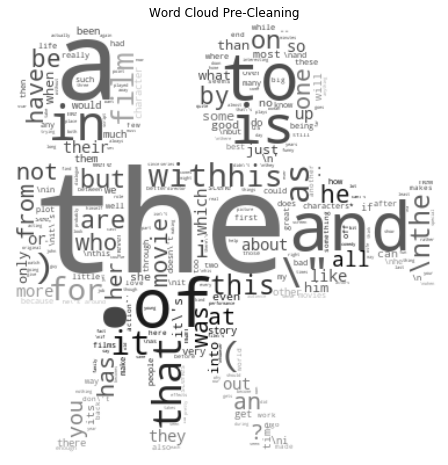

In [17]:
#mask from http://clipart-library.com/clipart/1517256.htm 
#creating an array of arrays for the mask 
word_cloud = create_word_cloud_with_mask("data//projector.png", review_dict, 750, "Word Cloud Pre-Cleaning")

#Without any preprocessing you can see the words that have the highest frequency count are not beneficial to the 
#understanding about what the review is about or the sentiment. The wordcloud shows that punctuation needs to be 
#removed as the common characters are ., \, /, ", ), ', \n, ?,. The most common words are the, a, to, and, is, in, of... 
#these words are not helpful and should be removed during the processing and cleaning of the data. My first step is 
#to remove punctuation and anything that is not a word. the words \nthe and \ni is there, which shows that I need to 
#remove the new line character as well. 

In [18]:
#Visualizing the top 12 words/characters
eda_reviews_top_words = word_freq_dict_to_df_top_words(review_dict, 12)
eda_reviews_top_words

count  word
22  68199   the
14  65876     .
7   37078     a
11  33723   and
21  33694    of
6   31466    to
60  25014    is
31  19943    in
41  17612    \"
49  14765  that
88  11781     )
83  11664     (

<module 'matplotlib.pyplot' from 'C:\\Users\\ho511\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

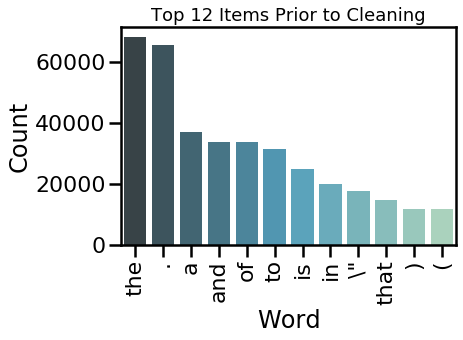

In [19]:
top_words_bar_plot(eda_reviews_top_words, "Top 12 Items Prior to Cleaning")

In [20]:
total_words_unique_words(review_dict)

The total number of words is 1418867
The total number of unique words is 56785


In [21]:
#need to remove the newline character \n
movies_clean["review"] = movies_clean["review"].str.replace(r'\\n', ' ', regex = True)
#Changing all n't to not 
movies_clean["review"] = movies_clean["review"].str.replace("n't"," not")
#Removing punctuation and making everything lowercase 
movies_clean["review"] = movies_clean["review"].str.replace('[^\w^\s]', "").str.lower()
#Need to tokenize 
movies_clean["review_tokenize"] = movies_clean.apply(lambda row: nltk.word_tokenize(row["review"]), axis = 1)

In [22]:
#Removing stopwords 
movies_clean["review_no_stopwords"] = movies_clean.apply(lambda row: stop_word_removal(row["review_tokenize"]), axis = 1)

In [23]:
#Visualizing the data without the stopwords 
viz = pd.DataFrame()
viz["no_stopwords"] = movies_clean["review_no_stopwords"].copy()

In [24]:
viz.head()

no_stopwords
0  [plot, two, teen, couples, go, church, party, ...
1  [happy, bastards, quick, movie, review, damn, ...
2  [movies, like, make, jaded, movie, viewer, tha...
3  [quest, camelot, warner, bros, first, featurel...
4  [synopsis, mentally, unstable, man, undergoing...

In [25]:
viz["no_stopwords"] = getting_data_ready_for_freq(viz, "no_stopwords")
no_stopwords_dict = creating_freq_list_from_df_to_dict(viz, "no_stopwords")
print(no_stopwords_dict)

Counter({'film': 8858, 'one': 5520, 'movie': 5438, 'like': 3553, 'even': 2555, 'good': 2320, 'time': 2283, 'story': 2117, 'films': 2105, 'would': 2041, 'much': 2023, 'also': 1965, 'characters': 1947, 'get': 1921, 'character': 1906, 'two': 1824, 'first': 1768, 'see': 1730, 'well': 1695, 'way': 1668, 'make': 1590, 'really': 1556, 'little': 1490, 'life': 1469, 'plot': 1451, 'people': 1419, 'movies': 1416, 'could': 1395, 'bad': 1373, 'scene': 1373, 'never': 1363, 'best': 1301, 'new': 1277, 'doesnt': 1271, 'many': 1267, 'man': 1266, 'scenes': 1265, 'dont': 1211, 'know': 1207, 'hes': 1150, 'great': 1140, 'another': 1111, 'love': 1089, 'action': 1078, 'go': 1075, 'us': 1065, 'director': 1056, 'something': 1048, 'end': 1047, 'still': 1037, 'back': 1034, 'seems': 1032, 'made': 1026, 'work': 1007, 'theres': 994, 'makes': 992, 'however': 986, 'big': 970, 'years': 968, 'world': 963, 'every': 945, 'though': 936, 'better': 914, 'enough': 907, 'seen': 902, 'around': 896, 'take': 893, 'performance': 8

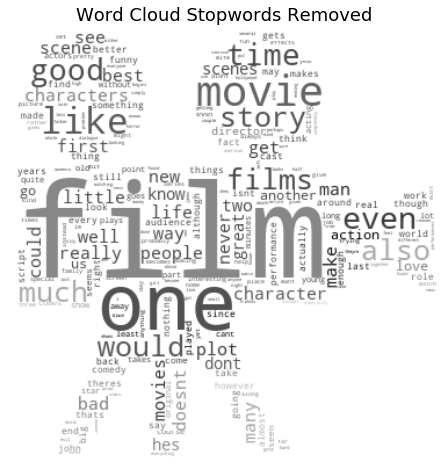

In [26]:
#creating an array of arrays for the mask 
word_cloud = create_word_cloud_with_mask("data//projector.png", no_stopwords_dict, 750, "Word Cloud Stopwords Removed")

In [27]:
#Visualizing the top 12 words/characters
eda_reviews_top_words = word_freq_dict_to_df_top_words(no_stopwords_dict, 12)
eda_reviews_top_words

count   word
104   8858   film
11    5520    one
22    5438  movie
87    3553   like
36    2555   even
51    2320   good
275   2283   time
276   2117  story
42    2105  films
189   2041  would
342   2023   much
233   1965   also

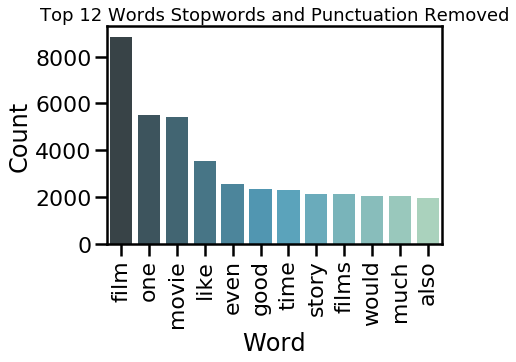

In [28]:
top_words_bar_plot(eda_reviews_top_words, "Top 12 Words Stopwords and Punctuation Removed")
sns.set_context("talk")

In [29]:
total_words_unique_words(no_stopwords_dict)

The total number of words is 710273
The total number of unique words is 47627


In [30]:
#Using the Porter Stemmer to tokenize 
#stemming using the porter stemmer. 
stemmed_movies = pd.DataFrame()
stemmed_movies["stemmed_review"] = movies_clean.apply(lambda row: stem_fun(row["review_no_stopwords"]), axis = 1)

In [31]:
#Visualizing the stemmed_movies df
stemmed_movies.head()

stemmed_review
0  [plot, two, teen, coupl, go, church, parti, dr...
1  [happi, bastard, quick, movi, review, damn, y2...
2  [movi, like, make, jade, movi, viewer, thank, ...
3  [quest, camelot, warner, bro, first, featurele...
4  [synopsi, mental, unstabl, man, undergo, psych...

In [32]:
#Visualizing the data without the stopwords 
viz = pd.DataFrame()
viz["stemmed_review"] = stemmed_movies["stemmed_review"].copy()

In [33]:
viz["stemmed_review"] = getting_data_ready_for_freq(viz, "stemmed_review")
stemmed_dict = creating_freq_list_from_df_to_dict(viz, "stemmed_review")
print(stemmed_dict)

Counter({'film': 11108, 'movi': 6855, 'one': 5758, 'like': 3997, 'charact': 3855, 'get': 3189, 'make': 3152, 'time': 2902, 'scene': 2638, 'even': 2602, 'good': 2383, 'play': 2361, 'stori': 2319, 'see': 2202, 'would': 2041, 'much': 2024, 'also': 1965, 'go': 1954, 'way': 1855, 'seem': 1834, 'look': 1825, 'end': 1825, 'two': 1824, 'take': 1799, 'first': 1769, 'come': 1765, 'well': 1756, 'work': 1693, 'thing': 1650, 'year': 1562, 'realli': 1556, 'plot': 1553, 'know': 1548, 'perform': 1522, 'littl': 1493, 'life': 1482, 'peopl': 1460, 'love': 1412, 'could': 1395, 'bad': 1382, 'never': 1364, 'man': 1353, 'tri': 1340, 'show': 1339, 'best': 1304, 'give': 1280, 'new': 1277, 'doesnt': 1271, 'mani': 1267, 'star': 1266, 'want': 1231, 'say': 1230, 'actor': 1229, 'director': 1217, 'dont': 1211, 'watch': 1206, 'find': 1201, 'great': 1176, 'action': 1172, 'use': 1163, 'becom': 1153, 'think': 1152, 'he': 1150, 'role': 1144, 'anoth': 1119, 'act': 1103, 'audienc': 1074, 'us': 1065, 'effect': 1064, 'back':

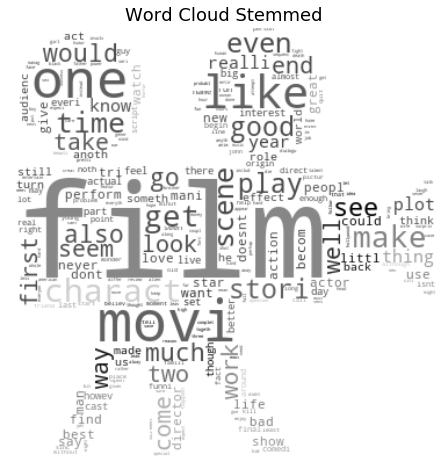

In [34]:
#creating an array of arrays for the mask 
word_cloud = create_word_cloud_with_mask("data//projector.png", stemmed_dict, 750, "Word Cloud Stemmed")

In [35]:
#Visualizing the top 12 words/characters
eda_reviews_top_words = word_freq_dict_to_df_top_words(stemmed_dict, 12)
eda_reviews_top_words

count     word
41   11108     film
22    6855     movi
11    5758      one
83    3997     like
77    3855  charact
9     3189      get
34    3152     make
253   2902     time
89    2638    scene
36    2602     even
50    2383     good
181   2361     play

<module 'matplotlib.pyplot' from 'C:\\Users\\ho511\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

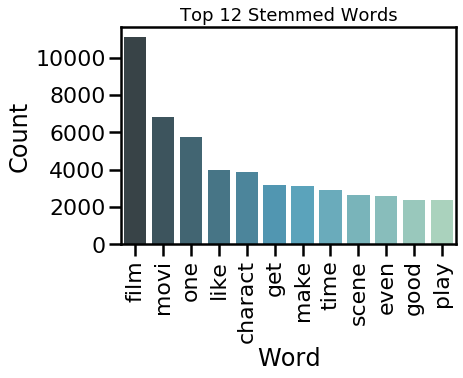

In [36]:
top_words_bar_plot(eda_reviews_top_words, "Top 12 Stemmed Words")

In [37]:
total_words_unique_words(stemmed_dict)

The total number of words is 710273
The total number of unique words is 32160


In [38]:
#Now, I am going to look at the lemmatizer 
lemma_movies = pd.DataFrame()
lemma_movies["lemma_review"] = movies_clean.apply(lambda row: lemma_func(row["review_no_stopwords"]), axis = 1)

In [39]:
viz = pd.DataFrame() 
viz["lemma_reviews"] = lemma_movies["lemma_review"].copy()

In [40]:
#Getting ready to visualize the data 
viz["lemma_reviews"] = getting_data_ready_for_freq(viz, "lemma_reviews")
lemma_dict = creating_freq_list_from_df_to_dict(viz, "lemma_reviews")
print(lemma_dict)

Counter({'film': 10963, 'movie': 6854, 'one': 5756, 'character': 3853, 'like': 3651, 'time': 2849, 'get': 2785, 'scene': 2638, 'make': 2582, 'even': 2559, 'good': 2338, 'story': 2319, 'would': 2041, 'much': 2023, 'also': 1965, 'see': 1866, 'way': 1855, 'two': 1824, 'life': 1807, 'first': 1769, 'go': 1727, 'well': 1709, 'thing': 1650, 'year': 1562, 'take': 1561, 'really': 1556, 'plot': 1510, 'come': 1502, 'little': 1493, 'know': 1485, 'people': 1459, 'could': 1395, 'bad': 1373, 'work': 1366, 'never': 1363, 'man': 1347, 'performance': 1315, 'end': 1304, 'best': 1302, 'new': 1277, 'look': 1272, 'doesnt': 1271, 'many': 1267, 'actor': 1229, 'director': 1213, 'dont': 1211, 'play': 1198, 'u': 1188, 'love': 1184, 'action': 1166, 'he': 1150, 'role': 1144, 'great': 1142, 'show': 1131, 'find': 1116, 'another': 1111, 'audience': 1074, 'give': 1068, 'star': 1058, 'say': 1058, 'something': 1048, 'back': 1043, 'still': 1042, 'seems': 1032, 'want': 1032, 'world': 1029, 'made': 1026, 'there': 994, 'how

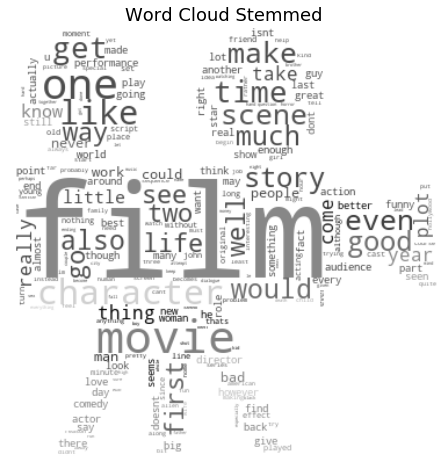

In [41]:
#creating an array of arrays for the mask 
word_cloud = create_word_cloud_with_mask("data//projector.png", lemma_dict, 750, "Word Cloud Stemmed")

In [42]:
#Visualizing the top 12 words/characters
eda_reviews_top_words = word_freq_dict_to_df_top_words(lemma_dict, 12)
eda_reviews_top_words

count       word
42   10963       film
22    6854      movie
11    5756        one
80    3853  character
86    3651       like
266   2849       time
9     2785        get
92    2638      scene
34    2582       make
36    2559       even
51    2338       good
267   2319      story

<module 'matplotlib.pyplot' from 'C:\\Users\\ho511\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

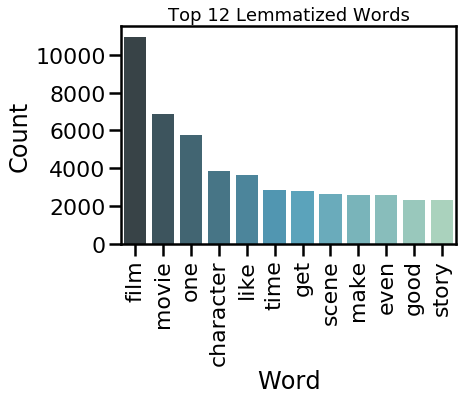

In [43]:
top_words_bar_plot(eda_reviews_top_words, "Top 12 Lemmatized Words")

In [44]:
total_words_unique_words(lemma_dict)

The total number of words is 710273
The total number of unique words is 42473


In [45]:
#Visualizing bigrams: 
lemma_bigrams = pd.DataFrame()
lemma_bigrams["lemma_review_bigrams"] = lemma_movies["lemma_review"].apply(lambda row: creating_ngrams(row, 2))

In [46]:
lemma_bigrams.head()

lemma_review_bigrams
0  [plot_two, two_teen, teen_couple, couple_go, g...
1  [happy_bastard, bastard_quick, quick_movie, mo...
2  [movie_like, like_make, make_jaded, jaded_movi...
3  [quest_camelot, camelot_warner, warner_bros, b...
4  [synopsis_mentally, mentally_unstable, unstabl...

In [47]:
#Visualizing the bigrams 
viz = pd.DataFrame() 
viz["lemma_bigrams"] = lemma_bigrams["lemma_review_bigrams"].copy()

In [48]:
#Getting ready to visualize the data 
viz["lemma_bigrams"] = getting_data_ready_for_freq(viz, "lemma_bigrams")
lemma_bigram_dict = creating_freq_list_from_df_to_dict(viz, "lemma_bigrams")

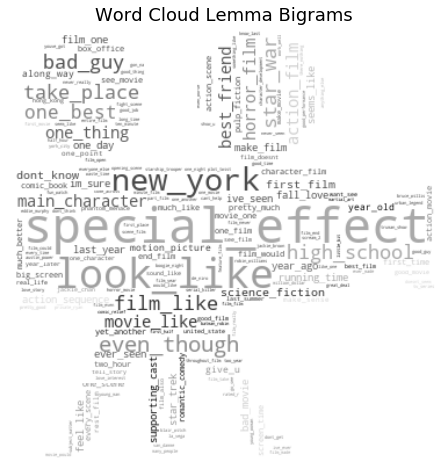

In [49]:
#creating an array of arrays for the mask 
word_cloud = create_word_cloud_with_mask("data//projector.png", lemma_bigram_dict, 750, "Word Cloud Lemma Bigrams")

In [50]:
#Visualizing the top 12 words/characters
eda_reviews_top_words = word_freq_dict_to_df_top_words(lemma_bigram_dict, 12)
eda_reviews_top_words

count            word
1048     387  special_effect
95       257       look_like
4787     249        new_york
1264     222     even_though
2849     183         bad_guy
3016     178     high_school
1782     173       film_like
1484     169      take_place
26071    166        star_war
7142     141        one_best
13755    139  main_character
169      133      movie_like

<module 'matplotlib.pyplot' from 'C:\\Users\\ho511\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

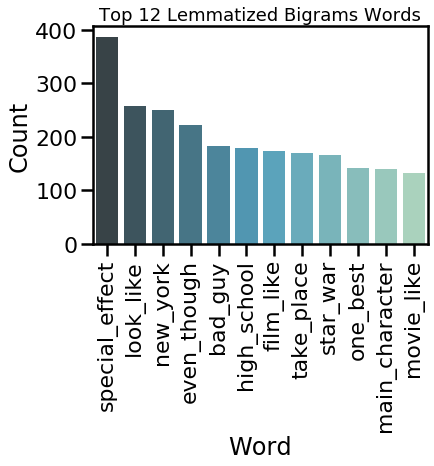

In [51]:
top_words_bar_plot(eda_reviews_top_words, "Top 12 Lemmatized Bigrams Words")

In [52]:
total_words_unique_words(lemma_bigram_dict)

The total number of words is 708273
The total number of unique words is 518043


In [53]:
#Visualizing the Trigrams 
lemma_trigrams = pd.DataFrame()
lemma_trigrams["lemma_review_trigrams"] = lemma_movies["lemma_review"].apply(lambda row: creating_ngrams(row, 3))

In [54]:
lemma_trigrams.head()

lemma_review_trigrams
0  [plot_two_teen, two_teen_couple, teen_couple_g...
1  [happy_bastard_quick, bastard_quick_movie, qui...
2  [movie_like_make, like_make_jaded, make_jaded_...
3  [quest_camelot_warner, camelot_warner_bros, wa...
4  [synopsis_mentally_unstable, mentally_unstable...

In [55]:
#Visualizing the trigrams 
viz = pd.DataFrame() 
viz["lemma_trigrams"] = lemma_trigrams["lemma_review_trigrams"].copy()

In [56]:
#Getting ready to visualize the data 
viz["lemma_trigrams"] = getting_data_ready_for_freq(viz, "lemma_trigrams")
lemma_trigram_dict = creating_freq_list_from_df_to_dict(viz, "lemma_trigrams")

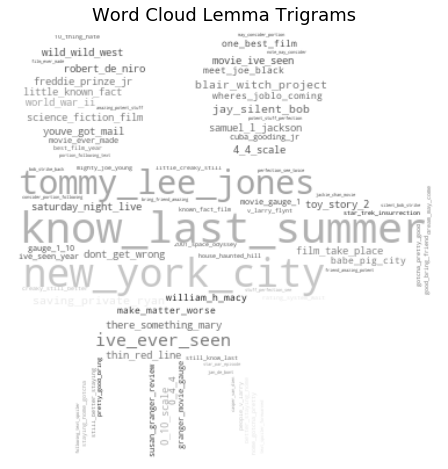

In [57]:
#creating an array of arrays for the mask 
word_cloud = create_word_cloud_with_mask("data//projector.png", lemma_trigram_dict, 750, "Word Cloud Lemma Trigrams")

In [58]:
#Visualizing the top 12 words/characters
eda_reviews_top_words = word_freq_dict_to_df_top_words(lemma_trigram_dict, 12)
eda_reviews_top_words

count                 word
27739      59     know_last_summer
25845      54        new_york_city
37571      44      tommy_lee_jones
47964      43  saving_private_ryan
4442       43        ive_ever_seen
101166     39       jay_silent_bob
17668      36  blair_witch_project
62757      32       robert_de_niro
71008      31       wild_wild_west
13101      30      film_take_place
13809      29       dont_get_wrong
75383      29     samuel_l_jackson

<module 'matplotlib.pyplot' from 'C:\\Users\\ho511\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

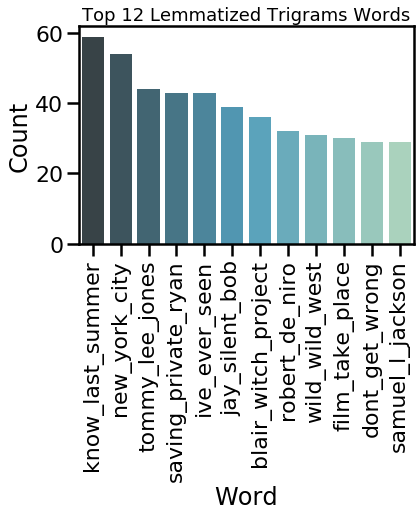

In [59]:
top_words_bar_plot(eda_reviews_top_words, "Top 12 Lemmatized Trigrams Words")

In [60]:
total_words_unique_words(lemma_trigram_dict)

The total number of words is 706273
The total number of unique words is 683103


In [61]:
#Attempting to create a bag of words from the stemmed data frame that has the stopped words removed: 
#Now I am going to create my bag of words and pd df before I move on to lemmatizing 
stemmed_bow = bag_of_words(stemmed_movies, "stemmed_review")

In [62]:
stemmed_bow[0]

Counter({'plot': 1,
         'two': 2,
         'teen': 4,
         'coupl': 1,
         'go': 4,
         'church': 1,
         'parti': 1,
         'drink': 1,
         'drive': 1,
         'get': 3,
         'accid': 1,
         'one': 3,
         'guy': 1,
         'die': 1,
         'girlfriend': 1,
         'continu': 1,
         'see': 2,
         'life': 1,
         'nightmar': 2,
         'what': 2,
         'deal': 1,
         'watch': 1,
         'movi': 7,
         'sorta': 1,
         'find': 1,
         'critiqu': 1,
         'mindfuck': 2,
         'gener': 2,
         'touch': 1,
         'cool': 2,
         'idea': 2,
         'present': 1,
         'bad': 2,
         'packag': 2,
         'make': 7,
         'review': 1,
         'even': 3,
         'harder': 1,
         'write': 1,
         'sinc': 2,
         'applaud': 1,
         'film': 8,
         'attempt': 1,
         'break': 1,
         'mold': 1,
         'mess': 1,
         'head': 1,
         'lost': 2,
 

In [63]:
stemmed_df = bow_to_df(stemmed_bow)

In [64]:
stemmed_df.head()
#When attempting to normalize this df, it took over 15 minutes and was still running... Therefore, it is apparent 
#that feature reduction needs to be introduced. I decided to remove words that are neutral... 

plot  two  teen  coupl  go  church  parti  drink  drive  get  ...  trueman  \
0     1    2     4      1   4       1      1      1      1    3  ...        0   
1     0    0     0      0   2       0      0      0      0    1  ...        0   
2     2    1     0      0   2       0      0      0      0    1  ...        0   
3     0    0     0      0   0       0      0      0      0    1  ...        0   
4     1    1     0      0   0       0      0      0      0    0  ...        0   

   overfli  vainli  allse  cageworld  snoot  tangerin  timbr  powaqqatsi  \
0        0       0      0          0      0         0      0           0   
1        0       0      0          0      0         0      0           0   
2        0       0      0          0      0         0      0           0   
3        0       0      0          0      0         0      0           0   
4        0       0      0          0      0         0      0           0   

   keyboardist  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 32160 columns]

In [65]:
#For my new feature reduction and word removal. I am not removing stopwords, but instead words that do not have a 
#significant postive or negative sentiment analyzer score. Scratch that, I had to remove stopwords and use it on 
#the lemmatized review otherwise I got an error that it was doing too much. 
final_df= pd.DataFrame()
final_df["reviews"] = lemma_movies.apply(lambda row: pos_neg_words(row["lemma_review"]), axis = 1)

In [66]:
final_df.head()

reviews
0  [party, accident, cool, bad, applaud, mess, lo...
1  [happy, bastard, damn, empty, like, like, wast...
2  [like, jaded, thankful, criminal, wrong, stole...
3  [steal, worried, challenger, promising, lively...
4  [unstable, save, fatal, accident, love, unsucc...

In [67]:
#Need to add the label back to the reviews 
final_df["label"] = movies_clean["label"]

In [68]:
final_df.head()

reviews label
0  [party, accident, cool, bad, applaud, mess, lo...   neg
1  [happy, bastard, damn, empty, like, like, wast...   neg
2  [like, jaded, thankful, criminal, wrong, stole...   neg
3  [steal, worried, challenger, promising, lively...   neg
4  [unstable, save, fatal, accident, love, unsucc...   neg

<module 'matplotlib.pyplot' from 'C:\\Users\\ho511\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

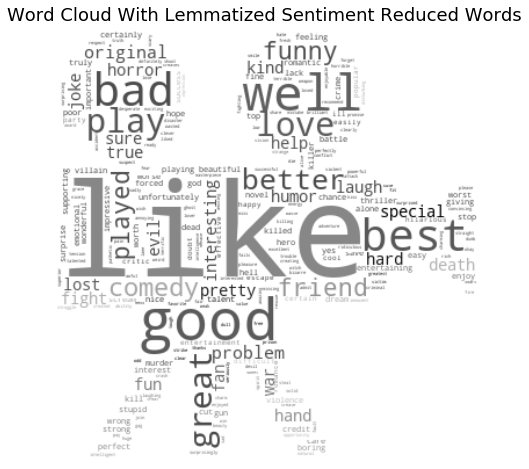

In [69]:
#Visualizing the df before running machine learning to see if the way I reduced the features allows for accurate prediction
#visualizing the further reduced dataset... 
#Creating a visualization df that I can manipulate when creating my visualizations 
viz = pd.DataFrame()
#copying my movies_stemmed df. 
viz["reviews"] = final_df["reviews"]
viz["reviews"] = getting_data_ready_for_freq(viz, "reviews")
movies_review_dict = creating_freq_list_from_df_to_dict(viz, "reviews")
#mask from http://clipart-library.com/clipart/1517256.htm 
#creating an array of arrays for the mask 
create_word_cloud_with_mask("data//projector.png", movies_review_dict, 750, "Word Cloud With Lemmatized Sentiment Reduced Words")

In [70]:
#Visualizing the top 12 words/characters
eda_reviews_top_words = word_freq_dict_to_df_top_words(movies_review_dict, 12)
eda_reviews_top_words

count    word
15    3651    like
7     2338    good
12    1709    well
3     1373     bad
54    1302    best
57    1198    play
110   1184    love
166   1142   great
168    918  better
96     886  comedy
217    829   funny
216    791  friend

<module 'matplotlib.pyplot' from 'C:\\Users\\ho511\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

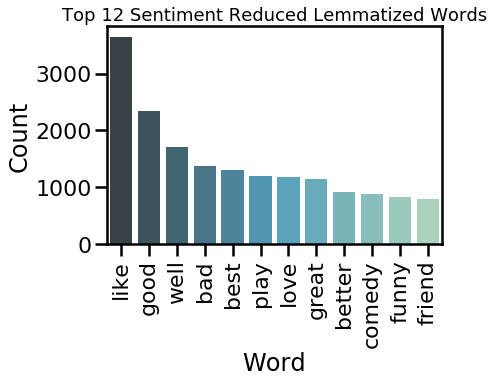

In [71]:
top_words_bar_plot(eda_reviews_top_words, "Top 12 Sentiment Reduced Lemmatized Words")

In [72]:
total_words_unique_words(movies_review_dict)

The total number of words is 109548
The total number of unique words is 3181


In [73]:
#Now, I am ready to create a bag of words and then my giant df with these reduced features... 
#Now I am going to create my bag of words and pd df before I move on to lemmatizing 
reduced_lemma_bow = bag_of_words(final_df, "reviews")

In [74]:
reduced_lemma_bow[0]

Counter({'party': 1,
         'accident': 1,
         'cool': 2,
         'bad': 2,
         'applaud': 1,
         'mess': 1,
         'lost': 2,
         'good': 2,
         'pretty': 5,
         'neat': 1,
         'terribly': 1,
         'problem': 3,
         'well': 1,
         'dream': 1,
         'dead': 2,
         'like': 3,
         'strange': 1,
         'weird': 1,
         'kind': 1,
         'hide': 2,
         'entertaining': 2,
         'thrilling': 1,
         'engaging': 1,
         'sad': 1,
         'sure': 1,
         'vision': 1,
         'lazy': 1,
         'okay': 1,
         'giving': 1,
         'playing': 1,
         'beauty': 1,
         'kudos': 1,
         'feeling': 1,
         'entertain': 1,
         'confusing': 1,
         'excites': 1,
         'craziness': 1,
         'horror': 1,
         'witch': 1})

In [75]:
reduced_df = bow_to_df(reduced_lemma_bow)

In [76]:
reduced_df.head()

party  accident  cool  bad  applaud  mess  lost  good  pretty  neat  ...  \
0      1         1     2    2        1     1     2     2       5     1  ...   
1      0         0     0    0        0     0     0     1       1     0  ...   
2      0         0     3    0        0     1     0     0       0     0  ...   
3      0         0     0    0        0     2     0     1       1     0  ...   
4      0         1     0    2        0     0     0     1       0     0  ...   

   complimented  isolationist  fearfully  sentimentalized  worsening  \
0             0             0          0                0          0   
1             0             0          0                0          0   
2             0             0          0                0          0   
3             0             0          0                0          0   
4             0             0          0                0          0   

   intellectualizing  motivate  douchebag  fiesta  felony  
0                  0         0          0       0       0  
1                  0         0          0       0       0  
2                  0         0          0       0       0  
3                  0         0          0       0       0  
4                  0         0          0       0       0  

[5 rows x 3181 columns]

In [77]:
#Now, I need to normalize the dataframe 
reduced_df = normalize_df(reduced_df)

In [78]:
reduced_df.head()

party  accident      cool       bad   applaud      mess      lost  \
0  0.018519  0.018519  0.037037  0.037037  0.018519  0.018519  0.037037   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.071429  0.000000  0.000000  0.023810  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.044444  0.000000   
4  0.000000  0.023810  0.000000  0.047619  0.000000  0.000000  0.000000   

       good    pretty      neat  ...  isolationist  fearfully  \
0  0.037037  0.092593  0.018519  ...           0.0        0.0   
1  0.083333  0.083333  0.000000  ...           0.0        0.0   
2  0.000000  0.000000  0.000000  ...           0.0        0.0   
3  0.022222  0.022222  0.000000  ...           0.0        0.0   
4  0.023810  0.000000  0.000000  ...           0.0        0.0   

   sentimentalized  worsening  intellectualizing  motivate  douchebag  fiesta  \
0              0.0        0.0                0.0       0.0        0.0     0.0   
1              0.0        0.0                0.0       0.0        0.0     0.0   
2              0.0        0.0                0.0       0.0        0.0     0.0   
3              0.0        0.0                0.0       0.0        0.0     0.0   
4              0.0        0.0                0.0       0.0        0.0     0.0   

   felony  total  
0     0.0     54  
1     0.0     12  
2     0.0     42  
3     0.0     45  
4     0.0     42  

[5 rows x 3182 columns]

In [79]:
#Now I need to re-add the labels 
reduced_df["label"] = final_df["label"]

In [80]:
reduced_df.head()

party  accident      cool       bad   applaud      mess      lost  \
0  0.018519  0.018519  0.037037  0.037037  0.018519  0.018519  0.037037   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.071429  0.000000  0.000000  0.023810  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.044444  0.000000   
4  0.000000  0.023810  0.000000  0.047619  0.000000  0.000000  0.000000   

       good    pretty      neat  ...  fearfully  sentimentalized  worsening  \
0  0.037037  0.092593  0.018519  ...        0.0              0.0        0.0   
1  0.083333  0.083333  0.000000  ...        0.0              0.0        0.0   
2  0.000000  0.000000  0.000000  ...        0.0              0.0        0.0   
3  0.022222  0.022222  0.000000  ...        0.0              0.0        0.0   
4  0.023810  0.000000  0.000000  ...        0.0              0.0        0.0   

   intellectualizing  motivate  douchebag  fiesta  felony  total  label  
0                0.0       0.0        0.0     0.0     0.0     54    neg  
1                0.0       0.0        0.0     0.0     0.0     12    neg  
2                0.0       0.0        0.0     0.0     0.0     42    neg  
3                0.0       0.0        0.0     0.0     0.0     45    neg  
4                0.0       0.0        0.0     0.0     0.0     42    neg  

[5 rows x 3183 columns]

In [81]:
#Creating a testing and training df for the large_df 
test_train = reduced_df.copy() 

test_train_label = test_train["label"]
#Now, I need to drop the label from the test_train_opinions df 
test_train.drop("label", axis = 1, inplace = True)

In [82]:
#Creating 4 df: 1: the training df with label removed, 2: the testing df with label removed, 3: the training label, 4: testing label
train, test, train_label, test_label = train_test_split(test_train, test_train_label, test_size = .3, random_state = 1006)

In [83]:
#Getting a count of positive and negative opinions in the test label 
print(Counter(test_label))
#That worked out perfectly! I have 300 negative reviews and 300 positive reviews; which means 
#I have 700 positive and 700 negative reviews in my training set.  

Counter({'pos': 300, 'neg': 300})


In [84]:
#Naive Bayes attempt 
clf = GaussianNB()
clf.fit(train, train_label)
test_predicted = clf.predict(test)

The accuracy is 0.6983333333333334


Text(0.5, 1, 'NB Gaussian Accuracy Score: 0.6983')

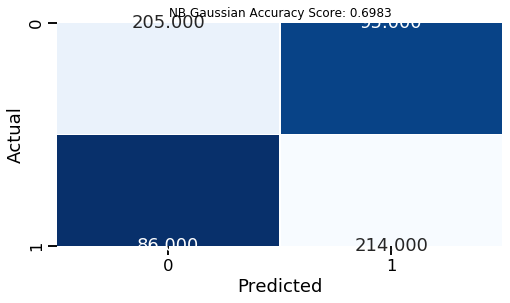

In [97]:
#Getting the accuracy for naive bayes 
accuracy = accuracy_score(test_label, test_predicted, normalize = True)
print("The accuracy is", accuracy)
cm = confusion_matrix(test_label, test_predicted)
confusion_matrix_graph(cm, accuracy, "NB Gaussian")
